In [10]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Dict, Optional
import pandas as pd
from openbox.utils.history import History

plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False


In [11]:
def load_history_from_json(json_path: str, config_space=None) -> History:
    history = History.load_json(filename=json_path, config_space=config_space)
    return history


def extract_observations_data(history: History, skip_first: bool = True) -> Dict[str, np.ndarray]:
    """
    从 History 对象中提取观察数据
    
    Args:
        history: History 对象
        skip_first: 是否跳过第一个 observation（默认配置），默认为 True
    
    Returns:
        dict with keys:
            - iterations: 迭代次数 (0, 1, 2, ...)
            - objectives: 目标函数值列表
            - elapsed_times: 累计时钟时间列表
            - best_objectives: 到当前迭代为止的最佳目标值
    """
    observations = list(history.observations)
    
    # 跳过第一个 observation（默认配置）
    if skip_first and len(observations) > 0:
        observations = observations[1:]
    
    iterations = np.arange(len(observations))
    objectives = []
    elapsed_times = []
    best_objective = float('inf')
    best_objectives = []
    
    cumulative_time = 0.0
    
    for obs in observations:
        if obs.objectives and len(obs.objectives) > 0:
            obj = obs.objectives[0]
            if np.isfinite(obj):
                objectives.append(obj)
                best_objective = min(best_objective, obj)
            else:
                objectives.append(float('inf'))
        else:
            objectives.append(float('inf'))
        
        if hasattr(obs, 'elapsed_time') and obs.elapsed_time is not None:
            cumulative_time += obs.elapsed_time
        elapsed_times.append(cumulative_time)
        
        if np.isfinite(objectives[-1]):
            best_objectives.append(min(best_objective, objectives[-1]))
        else:
            best_objectives.append(best_objective if best_objective < float('inf') else np.nan)
    
    return {
        'iterations': iterations,
        'objectives': np.array(objectives),
        'elapsed_times': np.array(elapsed_times),
        'best_objectives': np.array(best_objectives)
    }


In [12]:
def plot_iteration_history(
    histories_data: List[Dict[str, np.ndarray]],
    labels: Optional[List[str]] = None,
    title: str = "Optimization History",
    ylabel: str = "Objective Value",
    show_shadow: bool = True,
    shadow_type: str = "std",  # "std", "sem", "ci", "iqr"
    alpha: float = 0.3
):
    """
    绘制以迭代次数为横坐标的优化历史图
    
    Args:
        histories_data: 多个历史数据的列表，每个元素是 extract_observations_data 的返回值
        labels: 每个历史的标签列表
        title: 图表标题
        ylabel: Y轴标签
        show_shadow: 是否显示阴影区域
        shadow_type: 阴影类型
            - "std": 标准差 (mean ± std)
            - "sem": 标准误差 (mean ± SEM)
            - "ci": 95%置信区间
            - "iqr": 四分位距 (25%-75%)
        alpha: 阴影透明度
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if labels is None:
        labels = [f"Run {i+1}" for i in range(len(histories_data))]
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(histories_data)))
    
    for idx, data in enumerate(histories_data):
        iterations = data['iterations']
        objectives = data['objectives']
        best_objectives = data['best_objectives']
        
        # 过滤无效值
        valid_mask = np.isfinite(objectives)
        valid_iterations = iterations[valid_mask]
        valid_objectives = objectives[valid_mask]
        valid_best = best_objectives[valid_mask]
        
        if len(valid_objectives) == 0:
            continue
        
        # 绘制最佳值曲线
        ax.plot(valid_iterations, valid_best, 
                color=colors[idx], label=labels[idx], 
                linewidth=2, marker='o', markersize=4)
        
        # 绘制阴影区域（如果有多个历史数据）
        if show_shadow and len(histories_data) > 1:
            # 这里假设多个历史数据是多次运行的结果
            # 计算相同迭代次数的统计信息
            max_iter = max(len(d['iterations']) for d in histories_data)
            all_best_at_iter = []
            
            for i in range(max_iter):
                best_vals = []
                for d in histories_data:
                    if i < len(d['best_objectives']):
                        val = d['best_objectives'][i]
                        if np.isfinite(val):
                            best_vals.append(val)
                if best_vals:
                    all_best_at_iter.append(best_vals)
            
            if all_best_at_iter:
                means = [np.mean(vals) for vals in all_best_at_iter]
                if shadow_type == "std":
                    stds = [np.std(vals) for vals in all_best_at_iter]
                    upper = [m + s for m, s in zip(means, stds)]
                    lower = [m - s for m, s in zip(means, stds)]
                elif shadow_type == "sem":
                    sems = [np.std(vals) / np.sqrt(len(vals)) for vals in all_best_at_iter]
                    upper = [m + s for m, s in zip(means, sems)]
                    lower = [m - s for m, s in zip(means, sems)]
                elif shadow_type == "ci":
                    # 95% 置信区间 (使用 t 分布近似)
                    sems = [np.std(vals) / np.sqrt(len(vals)) for vals in all_best_at_iter]
                    ci_width = [1.96 * sem for sem in sems]  # 95% CI
                    upper = [m + w for m, w in zip(means, ci_width)]
                    lower = [m - w for m, w in zip(means, ci_width)]
                elif shadow_type == "iqr":
                    q75 = [np.percentile(vals, 75) for vals in all_best_at_iter]
                    q25 = [np.percentile(vals, 25) for vals in all_best_at_iter]
                    upper = q75
                    lower = q25
                
                iter_range = np.arange(len(means))
                ax.fill_between(iter_range, lower, upper, 
                               color=colors[idx], alpha=alpha, 
                               label=f"{labels[idx]} ({shadow_type.upper()})")
    
    ax.set_xlabel("Iteration", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, ax


In [13]:
def plot_time_history(
    histories_data: List[Dict[str, np.ndarray]],
    labels: Optional[List[str]] = None,
    title: str = "Optimization History (Wall-clock Time)",
    ylabel: str = "Objective Value",
    show_shadow: bool = True,
    shadow_type: str = "std",
    alpha: float = 0.3
):
    """
    绘制以时钟时间为横坐标的优化历史图
    
    参数同 plot_iteration_history，但横坐标是累计时钟时间
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if labels is None:
        labels = [f"Run {i+1}" for i in range(len(histories_data))]
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(histories_data)))
    
    for idx, data in enumerate(histories_data):
        elapsed_times = data['elapsed_times']
        objectives = data['objectives']
        best_objectives = data['best_objectives']
        
        # 过滤无效值
        valid_mask = np.isfinite(objectives) & np.isfinite(elapsed_times)
        valid_times = elapsed_times[valid_mask]
        valid_objectives = objectives[valid_mask]
        valid_best = best_objectives[valid_mask]
        
        if len(valid_objectives) == 0:
            continue
        
        # 绘制最佳值曲线
        ax.plot(valid_times, valid_best, 
                color=colors[idx], label=labels[idx], 
                linewidth=2, marker='o', markersize=4)
        
        # 阴影区域处理（类似迭代版本，但基于时间）
        if show_shadow and len(histories_data) > 1:
            # 对于时间轴，我们需要在相同的时间点进行插值
            max_time = max(np.max(d['elapsed_times']) for d in histories_data)
            time_points = np.linspace(0, max_time, 100)  # 100个时间点
            
            all_best_at_time = []
            for t in time_points:
                best_vals = []
                for d in histories_data:
                    times = d['elapsed_times']
                    bests = d['best_objectives']
                    # 找到最接近的时间点
                    if len(times) > 0:
                        idx_closest = np.argmin(np.abs(times - t))
                        if idx_closest < len(bests) and np.isfinite(bests[idx_closest]):
                            best_vals.append(bests[idx_closest])
                if best_vals:
                    all_best_at_time.append(best_vals)
            
            if all_best_at_time:
                means = [np.mean(vals) for vals in all_best_at_time]
                if shadow_type == "std":
                    stds = [np.std(vals) for vals in all_best_at_time]
                    upper = [m + s for m, s in zip(means, stds)]
                    lower = [m - s for m, s in zip(means, stds)]
                elif shadow_type == "sem":
                    sems = [np.std(vals) / np.sqrt(len(vals)) for vals in all_best_at_time]
                    upper = [m + s for m, s in zip(means, sems)]
                    lower = [m - s for m, s in zip(means, sems)]
                elif shadow_type == "ci":
                    sems = [np.std(vals) / np.sqrt(len(vals)) for vals in all_best_at_time]
                    ci_width = [1.96 * sem for sem in sems]
                    upper = [m + w for m, w in zip(means, ci_width)]
                    lower = [m - w for m, w in zip(means, ci_width)]
                elif shadow_type == "iqr":
                    q75 = [np.percentile(vals, 75) for vals in all_best_at_time]
                    q25 = [np.percentile(vals, 25) for vals in all_best_at_time]
                    upper = q75
                    lower = q25
                
                time_range = time_points[:len(means)]
                ax.fill_between(time_range, lower, upper, 
                               color=colors[idx], alpha=alpha,
                               label=f"{labels[idx]} ({shadow_type.upper()})")
    
    ax.set_xlabel("Wall-clock Time (seconds)", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, ax


## 关于阴影区域（Shadow Area）的说明

阴影区域通常表示**数据的不确定性或变异性**，常见类型包括：

1. **标准差 (Standard Deviation, STD)**: `mean ± std`
   - 表示数据点相对于平均值的离散程度
   - 约68%的数据点落在阴影区域内（正态分布假设）

2. **标准误差 (Standard Error of the Mean, SEM)**: `mean ± SEM`
   - SEM = std / √n，其中 n 是样本数
   - 表示平均值的估计精度，通常比标准差小

3. **置信区间 (Confidence Interval, CI)**: 通常是 95% CI
   - `mean ± 1.96 * SEM` (95%置信区间)
   - 表示真实平均值有95%的概率落在这个范围内

4. **四分位距 (Interquartile Range, IQR)**: 25%-75%分位数
   - 表示中间50%数据的分布范围
   - 对异常值更鲁棒


[2025-11-06 13:31:31,544][OpenBox][INFO][history.py:253] 102 observations updated in history.
[2025-11-06 13:31:31,554][OpenBox][INFO][history.py:1105] Loaded history (len=102) from /root/codes/multique_fidelity_spark/results/tpcds_100g/64u240n2____Wnone29Tnonek-1Cnonek51sigma2.0top_ratio0.8__Sfull__s42_2025-11-04-15-02-18-141231.json


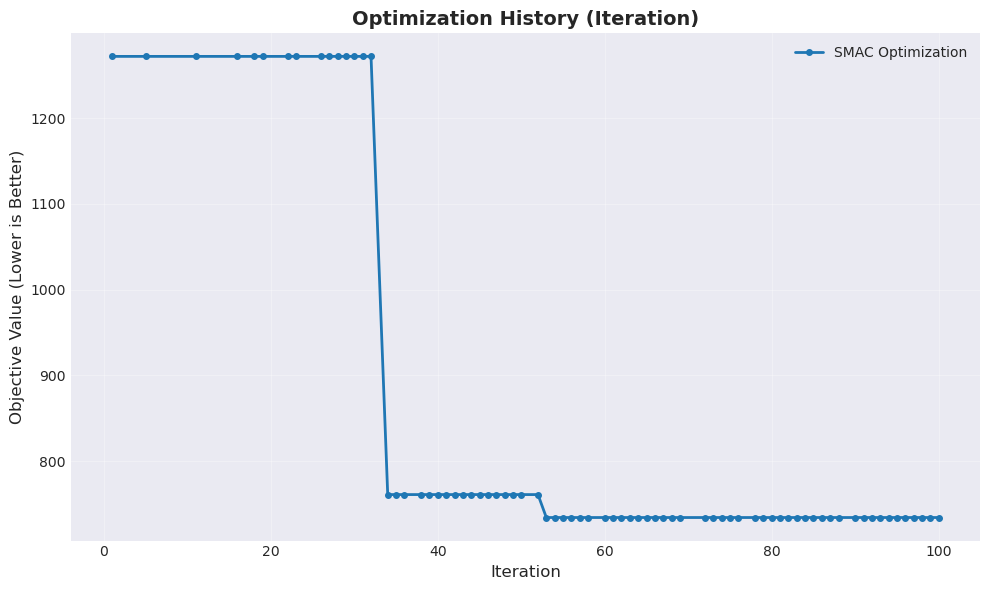

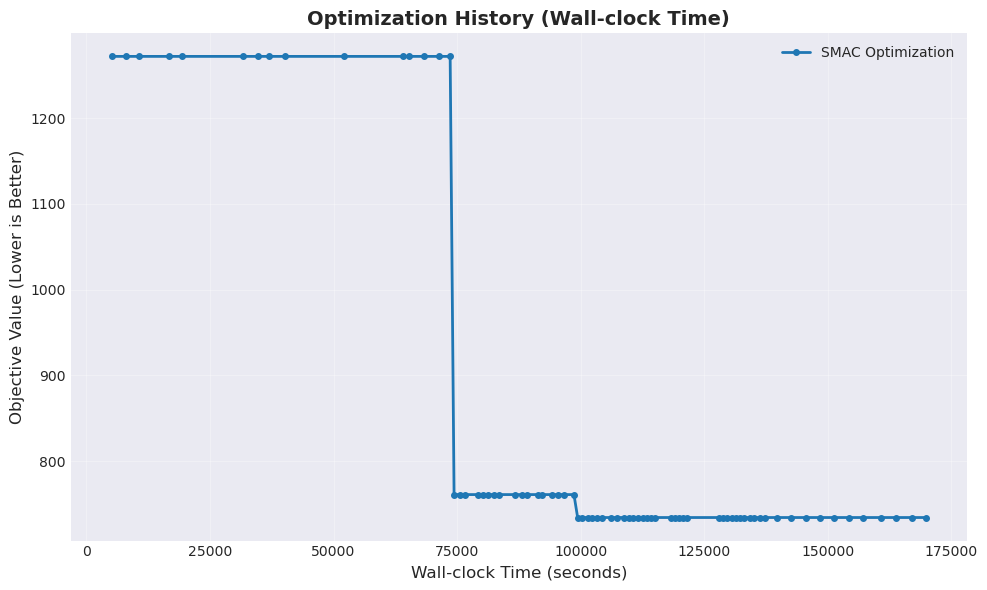

Total iterations: 101
Best objective: 734.23
Total time: 169883.69 seconds


In [14]:
if __name__ == "__main__" or True:
    import sys
    import os
    sys.path.insert(0, os.path.abspath('../..'))
    
    json_path = "/root/codes/multique_fidelity_spark/results/tpcds_100g/64u240n2____Wnone29Tnonek-1Cnonek51sigma2.0top_ratio0.8__Sfull__s42_2025-11-04-15-02-18-141231.json"
    
    from Optimizer.utils import load_space_from_json
    config_space = load_space_from_json(json_file="/root/codes/multique_fidelity_spark/configs/config_space/huge_space.json")

    history = load_history_from_json(json_path, config_space=config_space)
    data = extract_observations_data(history)
    
    # 绘制以迭代次数为横坐标的图
    fig1, ax1 = plot_iteration_history(
        [data],
        labels=["SMAC Optimization"],
        title="Optimization History (Iteration)",
        ylabel="Objective Value (Lower is Better)",
        show_shadow=False
    )
    plt.show()
    
    fig2, ax2 = plot_time_history(
        [data],
        labels=["SMAC Optimization"],
        title="Optimization History (Wall-clock Time)",
        ylabel="Objective Value (Lower is Better)",
        show_shadow=False
    )
    plt.show()
    
    print(f"Total iterations: {len(data['iterations'])}")
    print(f"Best objective: {np.nanmin(data['best_objectives']):.2f}")
    print(f"Total time: {data['elapsed_times'][-1]:.2f} seconds")


In [ ]:
# 示例：比较多个历史文件（如果有多个运行结果）
def compare_multiple_histories(json_paths: List[str], labels: Optional[List[str]] = None):
    """
    比较多个历史文件的优化结果
    
    Args:
        json_paths: JSON 文件路径列表
        labels: 可选的标签列表
    """
    histories_data = []
    for path in json_paths:
        history = load_history_from_json(path)
        data = extract_observations_data(history)
        histories_data.append(data)
    
    if labels is None:
        labels = [Path(p).stem for p in json_paths]
    
    # 绘制迭代图
    fig1, ax1 = plot_iteration_history(
        histories_data,
        labels=labels,
        title="Optimization History Comparison (Iteration)",
        ylabel="Objective Value",
        show_shadow=True,
        shadow_type="std"  # 可以改为 "sem", "ci", "iqr"
    )
    plt.show()
    
    # 绘制时间图
    fig2, ax2 = plot_time_history(
        histories_data,
        labels=labels,
        title="Optimization History Comparison (Wall-clock Time)",
        ylabel="Objective Value",
        show_shadow=True,
        shadow_type="std"
    )
    plt.show()

# 使用示例（如果有多个历史文件）
# json_paths = [
#     "path/to/history1.json",
#     "path/to/history2.json",
#     "path/to/history3.json"
# ]
# compare_multiple_histories(json_paths, labels=["Run 1", "Run 2", "Run 3"])
